In [46]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy import stats

import seaborn as sns

from ipywidgets import interact
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# More good news about death

In this notebook we're going to look at data from the [International Database on Longevity](http://www.supercentenarians.org/). It contains the ages at death of people who died at age 110 or above, so called supercentenarians. The IDL contains data from 15 countries, but we're only going to be looking at 4 of those countries: France, Japan, the USA and the UK. Those were the countries that were used in the paper [Evidence for a limit to human lifespan](http://www.nature.com/nature/journal/v538/n7624/full/nature19793.html).

I'm going to try and replicate their Figure 2 here. In a previous notebook I looked at the first figure in their paper. I'm not after a perfect replication - some of the details of the analysis aren't given in the paper - but I get pretty damn close with this one. The features in the second figure are, indeed, more robust than in the first Figure, but the "features" that are extracted from the data aren't perhaps quite so compelling a proof of their contention that there is a limit to human lifespan as the authors maintain. They fall short of supporting the claim that "the observed trajectories in Fig 2 are compelling and our results strongly suggest that human lifespan has a natural limit".

In [47]:
class supercentenarians:
    
    def __init__(self):
        
        self.years = []
        self.ages = []
        self.country = []
    
    def read_file(self, filename, country):
        f = open(filename, 'r')
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            if row[0] != "Id":
                self.ages.append(float(row[1]))
                years = row[8].split("/")
                self.years.append(float(years[-1]))
                self.country.append(country)
        pass
    
    def get_number_by_year(self):
        outyears = list(set(self.years))
        numsforyear = []
        for year in outyears:
            numsforyear.append(self.years.count(year))
        return outyears, numsforyear
    
    def get_nth_highest_by_year(self, pos):
        
        allyears = list(set(self.years))
        
        outyears = []
        nth_highest_for_year = []
        
        for year in allyears:
            indices = [i for i,x in enumerate(self.years) if x==year]
            allages = []
            for i in indices:
                allages.append(self.ages[i])
            allages.sort(reverse=True)
            if len(allages) > pos-1:
                nth_highest_for_year.append(allages[pos-1])
                outyears.append(year)
            
        return outyears, nth_highest_for_year
    
    def get_avg_by_year(self):
        
        outyears = list(set(self.years))
        avgsforyear = []
        for year in outyears:
            indices = [i for i,x in enumerate(self.years) if x==year]
            avgforyear = 0
            numforyear = 0
            for i in indices:
                avgforyear += self.ages[i]
                numforyear += 1.0
            avgsforyear.append(avgforyear/numforyear)
        
        return outyears, avgsforyear
    
    def get_max_by_year(self):
        
        outyears = list(set(self.years))
        maxsforyear = []
        for year in outyears:
            indices = [i for i,x in enumerate(self.years) if x==year]
            maxforyear = 0
            for i in indices:
                if self.ages[i] > maxforyear:
                    maxforyear = self.ages[i]
            maxsforyear.append(maxforyear)
        
        return outyears, maxsforyear

So here goes, first we're going to read in the data. I downloaded the data for each country as csv files (all, helpfully, called data.csv) and renamed them to something more memorable: France_data.csv for example. 

In [48]:
ct = supercentenarians()

ct.read_file('data/France_data.csv', 'France')
ct.read_file('data/UK_data.csv', 'UK')
ct.read_file('data/USA_data.csv', 'USA')
ct.read_file('data/Japan_data.csv', 'Japan')

ct_france = supercentenarians()
ct_usa = supercentenarians()
ct_uk = supercentenarians()
ct_japan = supercentenarians()

ct_france.read_file('data/France_data.csv', 'France')
ct_uk.read_file('data/UK_data.csv', 'UK')
ct_usa.read_file('data/USA_data.csv', 'USA')
ct_japan.read_file('data/Japan_data.csv', 'Japan')


The first thing to do is to plot those four data sets individually. This gives you an idea of what time period the four data sets cover and what their particular characteristics are. The French data run from around 1986 and stop in 2004. The UK data run from 1968 and stop in 2006. The US data from 1980 to 2004 and the Japanese data from 1996 to 2005. For some age-year combinations there are more than one point, but obviously these can't be seen.

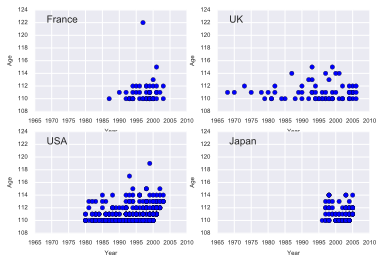

In [49]:
plt.figure(1)

def plotfourup(pos,inct,name):
    ax = plt.subplot(pos, xlabel='Year', ylabel='Age')
    plt.scatter(inct.years, inct.ages)
    plt.text(1968.5,122,name)
    plt.axis((1965,2010,108,124))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
        
plotfourup(221,ct_france,'France')
plotfourup(222,ct_uk,'UK')
plotfourup(223,ct_usa,'USA')
plotfourup(224,ct_japan,'Japan')

plt.show()


In the paper, these four data sets were combined. The combined data sets are shown below in the first panel and the total number of supercentenarian deaths in each year is shown in the lower panel. You can see that different data sets contribute at different points in time. For the first ten years or so - from 1968 to 1979 - the only dataset contributing is the UK with very few entries. In 1980, the US dataset starts up with numerous entries. In 1987, the French data set starts and then in 1996, the very short Japanese dataset begins. The end dates are staggered also with 2006 being based only on the UK data again.

Something else to notice is that between 1968 and 1980, there are a number of years which don't have an entry in any of the data sets.

My feeling is that one ought to be very cautious of combining such data sets and then using them to assess trends. Changes in the combined data set over time will be caused by: the different sizes of the populations of the countries considered; the mortality profile in each of the individual countries; problems with reporting in each of the countries (if any); any actual changes in mortality in each country over the full period; and, finally, the thing we are interested in, which is the general, international, background changes in mortality.

Just writing down what the authors are apparently hoping to extract from this combined data set suggests that they have set themselves a very difficult task.

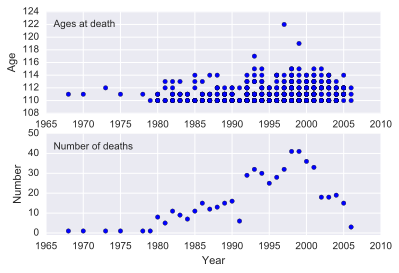

In [50]:
plt.subplot(211, xlabel='Year', ylabel='Age')
plt.scatter(ct.years,ct.ages)
plt.text(1966,121.6,'Ages at death')
plt.axis((1965,2010,108,124))

y,n = ct.get_number_by_year()

plt.subplot(212, xlabel='Year', ylabel='Number')
plt.scatter(y,n)
plt.text(1966, 42, 'Number of deaths')
plt.axis((1965,2010,-1,50))

plt.show()


Figure 2a from the paper shows the Maximum Reported Age at Death (MRAD), which is reproduced below. Between 1968 and 2006, a total of 39 years, there are 33 data points. This may be because no one died at age 110 or over in any of the countries in those years, or that any such deaths weren't reported or both.

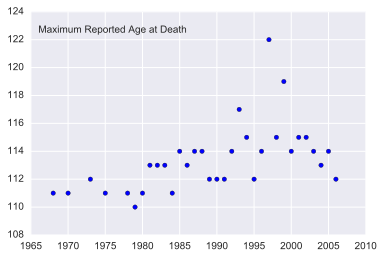

In [51]:
y,m = ct.get_max_by_year()
plt.scatter(y,m)
plt.axis((1965,2010,108,124))
plt.text(1966, 122.5, 'Maximum Reported Age at Death')
plt.show()


These points are the extreme points of a rather complex distribution. Performing a trend analysis on these points has all the difficulties previously mentioned and then some. In particular, one might worry that values below 110 are omitted from the data base. Their exclusion will tend to skew any trend to be too low unless special methods are applied (there are standard methods for dealing with absent data) or perhaps contribute to the spurious impression of a plateau in the data.

Nonetheless, the authors choose to perform linear fits to two separate periods: 1968-1994 and 1995-2006. They don't say exactly why they choose this point to make the break, simply stating that "it reached a plateau around 1995". There are no objective means given for ascertaining that this is where a break happened.

One could argue that the trend analysis in some sense justifies the decision to place a break at that exact point; the trend in the first part of the data is positive and the trend in the latter half inconclusively negative, but that's a bit circular.

We can easily look at what effect that choice has. The plot below breaks the period into two parts and fits a linear model to each, ignoring the missing values. There's no obvious, natural point at which the data "break". If we set the break to 1994, we get the exact results shown in Figure 2a in the paper. From this we can deduce that no special method was used to deal with the missing values early on in the record. I know this because I didn't do anything special; it's just a fit to the data shown in the diagram.

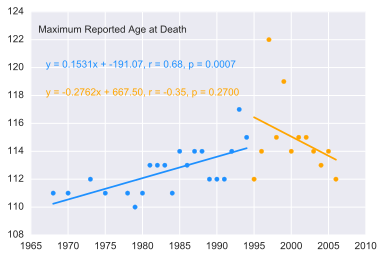

In [52]:
y,m = ct.get_max_by_year()

def split_trend_in_mrad(break_year=1994):
    y1 = []
    m1 = []
    y2 = []
    m2 = []
    
    for i, val in enumerate(y):
        if val <= break_year:
            y1.append(val)
            m1.append(m[i])
        else:
            y2.append(val)
            m2.append(m[i])
    
    slope1, intercept1, r_value1, p_value1, std_err = stats.linregress(y1,m1)
    slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(y2,m2)
    
    leg1 = "y = {:.4f}x + {:.2f}, r = {:.2f}, p = {:.4f}".format(slope1, intercept1, r_value1, p_value1)
    leg2 = "y = {:.4f}x + {:.2f}, r = {:.2f}, p = {:.4f}".format(slope2, intercept2, r_value2, p_value2)
       
    plt.scatter(y1,m1, color="DodgerBlue")
    plt.plot(y1,np.asarray(y1)*slope1 + intercept1, color="DodgerBlue")
    plt.text(1967,120,leg1, color="DodgerBlue")
    plt.scatter(y2,m2, color="Orange")
    plt.plot(y2,np.asarray(y2)*slope2 + intercept2, color="Orange")
    plt.text(1967,118,leg2, color="Orange")
    
    plt.axis((1965,2010,108,124))
    plt.text(1966, 122.5, 'Maximum Reported Age at Death')
    plt.show()

split_trend_in_mrad()


Two other things to notice. First: the trend is sensitive to the very high value in 1997; trends that start or end in 1997 are quite different from those that end in 1996 and start in 1998. An outlier can make quite a difference. Second: if one splits the period in two and makes the second period short enough, there will (almost) always be a significant trend in the first part and and insignificant trend in the shorter second part, so the trend assessment doesn't really tell us anything and it doesn't justify placing the break where the break is placed or support the interpretation of the data as a rise followed by a plateau.

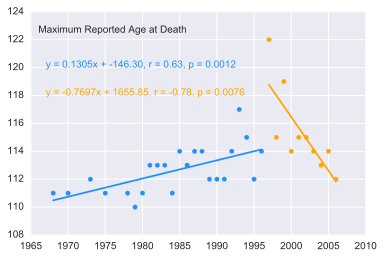

In [53]:
y,m = ct.get_max_by_year()
split_trend_in_mrad(1996)

The question here is really, is a linear fit with a break the best model of the data and here, I think, we must answer, categorically: no.

For a start, if you play around with where the break is, it's obvious that the break leads to a discontinuous process. The ends of the lines that were fit to the data don't joinr up, which doesn't tie in with contention of the authors that longevity was increasing and then reached some sort of natural ceiling. That suggests a smooth process, but what is the process that the authors think is leading to this plateau? It's not clearly stated.

The data don't obviously conform to the usual assumptions made in linear regression either, which are that the data are generated by a process that is linear with normally-distributed deviations from the linear bit. If we think about what is going on in the MRAD plot, it's clearly more complex than that. The data points are the maximum values above a particular threshold (110 years) from a distribution that is a varying mixture of inputs from four different countries. The hypothesis proposed by the authors is that longevity increased by some mechanism, but lately had hit some kind of natural limit. Anyway, best to stop trying to work out what they might have meant and get back to what they did.

The authors note that "_one potential confounder of [their] results is the fairly small number of reported MRAD cases, which could explaint these results simply as fluctuations._" They continue, "_to provide a robust statistical model that would strengthen the observed pattern, we considered several series of high reported age at death (HRAD), that is, the highest RAD (MRAD) and the second to the fifth highest RADs... All series showed the same pattern as the MRAD_."

The next plot shows all the data from the four countries in light grey and highlights the nth highest in red.

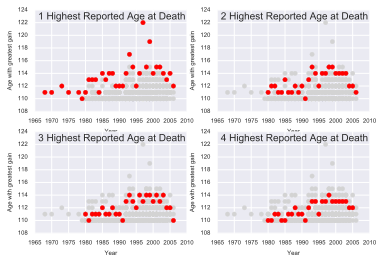

In [54]:
def plot_hrad(nth_highest,pos):
    y,m = ct.get_nth_highest_by_year(nth_highest)
    title = "{}".format(nth_highest)
    
    ax = plt.subplot(pos, xlabel='Year', ylabel='Age with greatest gain')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
    plt.scatter(ct.years,ct.ages, color="lightgrey")
    plt.scatter(y,m, color="red")
    plt.axis((1965,2010,108,124))
    plt.text(1966, 122.5, title+' Highest Reported Age at Death')


plot_hrad(1,221)
plot_hrad(2,222)
plot_hrad(3,223)
plot_hrad(4,224)
plt.show()


Does the similarity of the HRAD strengthen the observed "pattern" seen in the MRAD? I would say that it depends on the extent to which such a similarity would be surprising in a set of random numbers that had been processed in the same way. In fact, by that standard it isn't surprising at all. If you take a set of random numbers, sort them into order and repeat to create a series of the highest, second highest, third highest and so on, then those series will be correlated. The second highest is constrained to be below the first so the two are clearly related. The effect is likely to be exacerbated by the large change in the number of entries - more entries implies a higher probability of someone in that group reaching an especially advanced age.

The plot below is generated using normally-distributed random numbers. For each point, I draw 10000 samples from the distribution and sort them. I then take the highest (red) and nth highest (blue). Each time this script is run, it generates a new set of random numbers so ymmv.

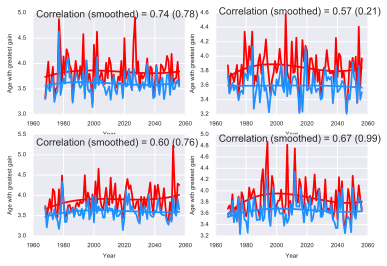

In [59]:
import numpy.random as nprnd
from scipy.interpolate import UnivariateSpline

def plot_randoms(pos,nth):
    rang = range(1968,2057)
    mrad = []
    hrad2 = []
    for i in rang:
        arr = nprnd.normal(0,1,10000)
        #arr = nprnd.rayleigh(0.25,10000)
        arr.sort()
        arr[:] = arr[::-1]
        mrad.append(arr[0])
        hrad2.append(arr[nth-1])
    
    sp1 = UnivariateSpline(rang, mrad)
    sp2 = UnivariateSpline(rang, hrad2)
    
    ax = plt.subplot(pos, xlabel='Year', ylabel='Age with greatest gain')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

    plt.plot(rang, mrad, color="red")
    plt.plot(rang, sp1(rang), color="red")
    plt.plot(rang, hrad2, color="dodgerblue")
    plt.plot(rang, sp2(rang), color="dodgerblue")
    
    plt.text(1962,max(mrad),
             "Correlation (smoothed) = {:.2f} ({:.2f})".format(stats.pearsonr(mrad,hrad2)[0], 
                                                               stats.pearsonr(sp1(rang),sp2(rang))[0]))
    
    pass

plot_randoms(221,2)
plot_randoms(222,2)
plot_randoms(223,2)
plot_randoms(224,2)

plt.show()

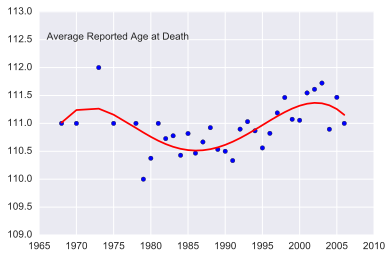

In [56]:
y,m = ct.get_avg_by_year()
plt.scatter(y,m)
sp1 = UnivariateSpline(y,m, k=5)
plt.plot(y, sp1(y), color="red")
plt.axis((1965,2010,109,113))
plt.text(1966, 112.5, 'Average Reported Age at Death')
plt.show()

The plot shows the average age at death of the supercentenarians in each year as blue spots. I've also run a spline smoother through the data (red line). About their smoothed line, the authors say "_Notably, even the annual average age at death for these supercentenarians has not increased since 1968_"

The first six blue points are all averages based on a single number as there is only a single entry/death in each of those years (all from the UK at this time). The supercentenarians who died in these years died at ages 111, 111, 112, 111, 111 and 110. From around 1980, the number of supercentenarians increases and the average drops. I suspect that this is principally because the majority of the mass of the distribution of ages in any given year is down at 110, the lowest value it can be. At the end of the series, the number of supercentenarians drops again. At the last point, there are only three entries with ages 110, 111 and 112.

The spline treats all of these values as equal, but they're not. If we imagine what the uncertainty in the estimate of the population mean is, it's likley to be larger at the start and end. The sample sizes vary widely as do a number of other things mentioned above. Failure to control for these effects means that we should have little confidence in the "trends" drawn over the data shown in Figure 2.

## Conclusion

In conclusion, the data presented in Figure 2 are not sufficiently homogeneous to be used for identifying long term changes or plateaus in the data. In addition, the methods employed to analyse the data are subjective (choice of break in the linear trends) not appropriate (linear trends) or give similar results to the same analysis performed on random data (Fig 2b). Or do not take into account the number and nature of the data (Fig 2c).

The authors claim that: 

“our data strongly suggest that the duration of human life is limited”

“Our results strongly suggest that the maximum lifespan of humans is fixed and subject to natural constraints”

“the observed trajectories in Fig 2 are compelling and our results strongly suggest that human lifespan has a natural limit.”

I am not convinced that the analysis presented in the paper strongly suggests anything. Nor is it compelling. The observed patterns, which the authors find convincing, arise from questionable analytic choices or rely on data that are not appropriate for such an analysis. Although I have only closely analysed the data used in the main paper and not strayed into the supplementary information, the data in the main paper are likely to be representative of the best available and not the worst. A quick glance at the supplementary figures shows that the data there have issues that are at least as problematic as the data used in Figures 1 and 2 of the main paper. For example, extended data figure 6 shows data from 1956 (or thereabouts) to 2015 (ish), but the caption states (1972-2015) it also has a gap in the late 80s/early 90s that is not explained. Even with these handicaps, it manages to give an impression utterly contrary to the one the authors try to impress upon it.

However, there is a more fundamental problem with the paper which all of this analysis serves partially to obscure.

The fundamental problem is that no hypotheses are being tested in the paper, no predictions (bold or otherwise) are made and tested against data. The narrative in the paper is largely descriptive. The data are processed in various ways and a story is woven around them. It is often said that extraordinary claims require extraordinary evidence. The idea that there is some natural limit to human lifespan at around 115 years is quite extraordinary. Sadly, this evidence isn't.